# 3주차 Multilayer perceptron

<img src='https://d2l.ai/_images/mlp.svg'>




## 3.1 Activation function

In [ ]:
!pip install --quiet d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

### a. ReLU

현재까지 널리 사용되면서, 적용하기 쉬운 비선형 활성화 함수 *rectified linear unit* **(ReLU)** 함수를 그려봅시다.


$$ \texttt{ReLU}(x)=\max\{x, 0\} $$



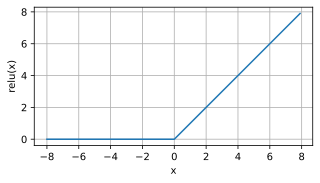

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))


ReLU 함수의 미분꼴은 *heavyside function* 입니다.

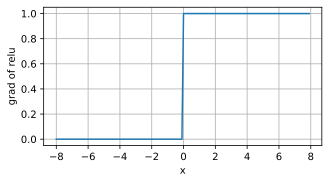

In [ ]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

* ReLU 함수를 직접 구현해봅시다!

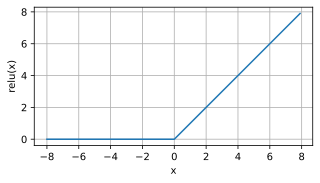

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.max(torch.zeros_like(x), x)

d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

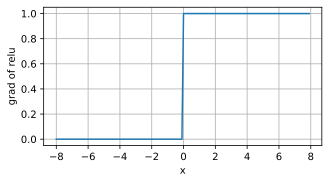

In [ ]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

### b. Sigmoid

Sigmoid 함수는 실수 전체 $\mathbb{R}$ 도메인을 $(0, 1)$ 구간으로 맵핑하는 함수입니다.

$$ \texttt{Sigmoid}(x)={1\over 1+\exp(-x)}  $$


기울기 기반 학습 과정에서 sigmoid 는 부드럽고 미분가능한 좋은 성질을 가진 함수입니다.

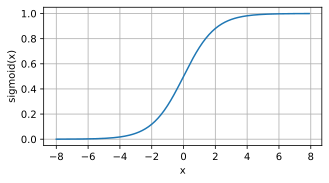

In [ ]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

한편 sigmoid 함수의 미분은 다시 자기자신을 이용한 형태로 나타납니다.

$$ {d\over dx}\texttt{sigmoid}(x)={\exp(-x)\over(1+\exp(-x))^2}=\texttt{sigmoid}(x)(1-\texttt{sigmoid}(x)). $$

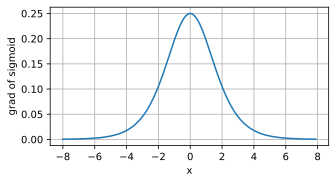

In [ ]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

* Sigmoid 함수를 직접 구현해봅시다!

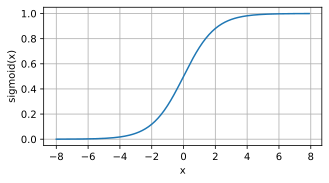

In [ ]:
y = 1 / (1 + torch.exp(-x))

d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

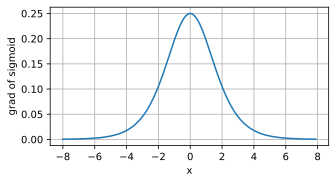

In [ ]:
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

## 3.2 MLP implementation



In [ ]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer ##, load_digits, load_wine ##

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Step 1. Load dataset

In [ ]:
data = load_breast_cancer()

In [ ]:
input = data.data
output = data.target

* GPU 사용이 가능하다면 device 를 GPU 로 설정!

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

* 데이터를 미리 설정한 device 로 이동합니다.

In [ ]:
## Split datasets
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

## Retrieve length of the inputs
x_len = len(x_train[0])
y_len = len(y_train.unique())

In [ ]:
print(x_train[0])
print(y_train[0])

tensor([1.1620e+01, 1.8180e+01, 7.6380e+01, 4.0880e+02, 1.1750e-01, 1.4830e-01,
        1.0200e-01, 5.5640e-02, 1.9570e-01, 7.2550e-02, 4.1010e-01, 1.7400e+00,
        3.0270e+00, 2.7850e+01, 1.4590e-02, 3.2060e-02, 4.9610e-02, 1.8410e-02,
        1.8070e-02, 5.2170e-03, 1.3360e+01, 2.5400e+01, 8.8140e+01, 5.2810e+02,
        1.7800e-01, 2.8780e-01, 3.1860e-01, 1.4160e-01, 2.6600e-01, 9.2700e-02],
       device='cuda:0')
tensor(1, device='cuda:0')


## Step 2 : CustomDataset 과 DataLoader

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [ ]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size)

## Step 3 : Define "Model"

* activation function 이용

  * nn.Sigmoid()
  * nn.ReLU()
  * nn.tanH()


* batch normazliation 1d 란?
  * 파라미터 값으로 vector의 길이를 전해줌



* a. 직접 nn.Sequential() 로 구현하기

In [ ]:
# input_layer에 들어가는 최초의 input 크기를 맞춰주자!
# output_layer로 출력되는 마지막 output 의 크기도 마찬가지.

model = nn.Sequential(
          nn.Linear(x_len ,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398, 15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15, y_len, bias=True),
          nn.Softmax()
          ).to(device)

* b. 파이썬 Class 로 구현하기

In [ ]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(x_len ,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(398, 15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, y_len, bias=True), # hidden_layer3 = 10, output_layer = 2
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

* Weight initialization

In [ ]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

In [ ]:
model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-23-6dcf2c5a1d5c>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


## Step 4 : Loss function 과 Optimizer

* 다양한 optimizer 가 존재
  * https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조

In [ ]:
loss_fn  = nn.CrossEntropyLoss().to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr= 0.01)

## Step 5: Train Model

In [ ]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 0.741421103477478
10 0.5063179135322571
20 0.42135950922966003
30 0.3962841033935547
40 0.38843148946762085
50 0.3830665349960327
60 0.40513870120048523
70 0.3734109699726105
80 0.3830457031726837
90 0.36680924892425537


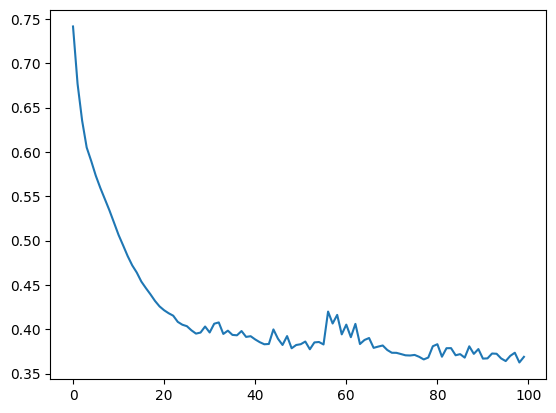

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [ ]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.01012038 0.9898796 ]
argmax를 한 후의 output은 1
accuracy는 0.9064327485380117


# MLP 를 다뤄봅시다!

위 코드를 참고하여 직접 MLP 를 구현해봅시다.

load_digits() 또는 load_wine() 중 하나를 골라 시도해보세요!

- lr, optimizer, hidden layer(depth), neuron 수(width)를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!

#digit data

## 1. 데이터 로드 및 전처리

In [ ]:
import torch
from torch import nn, optim
from sklearn.datasets import load_digits
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load_digits
data = load_digits()

print("data:", data.data, '\n')
print("target:", data.target)

data: [[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]] 

target: [0 1 2 ... 8 9 8]


데이터의 크기: (1797, 64)
이미지 한장의 크기: (8, 8) 



<Figure size 640x480 with 0 Axes>

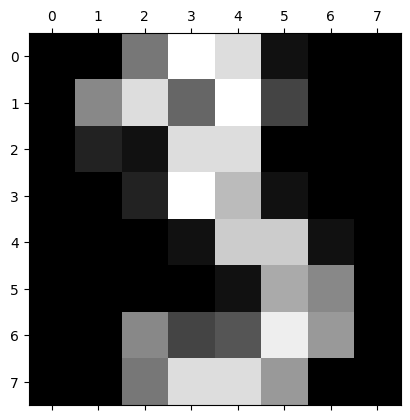

In [ ]:
print('데이터의 크기:', data.data.shape)
print('이미지 한장의 크기:', data.images[0].shape, '\n')

plt.gray()
plt.matshow(data.images[3])
plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
    torch.cuda.manual_seed_all(777)

In [ ]:
x = data.data
y = data.target

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42, stratify = data.target, shuffle = True)

# train 데이터 텐서 변환
x_train = torch.FloatTensor(x_train) # 32비트의 부동 소수점 (실수)
y_train = torch.LongTensor(y_train)  # 64비트의 부호가 있는 정수

# test 데이터 텐서 변환
x_test = torch.FloatTensor(x_test) # 32비트의 부동 소수점 (실수)
y_test = torch.LongTensor(y_test)  # 64비트의 부호가 있는 정수

## label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문

In [ ]:
# x의 feature : 64개 (8*8 pixel)
# y의 class : 10개 (0~9)
print('x의 feature(개) :', len(x_train[0]))
print('y의 class(개) :', len(set(y)))

# 예시 데이터
print(x_train[0])
print(y_train[2], '\n')

x의 feature(개) : 64
y의 class(개) : 10
tensor([ 0.,  0.,  0., 16., 12.,  1.,  0.,  0.,  0.,  0.,  6., 16., 14.,  7.,
         0.,  0.,  0.,  0., 14., 15.,  1., 11.,  0.,  0.,  0.,  0., 16., 15.,
         0., 14.,  1.,  0.,  0.,  1., 16., 10.,  0., 14.,  2.,  0.,  0.,  0.,
        15., 13.,  3., 15.,  3.,  0.,  0.,  0.,  9., 16., 16., 15.,  0.,  0.,
         0.,  0.,  0., 13., 16.,  8.,  0.,  0.])
tensor(1) 



파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. <br>
이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것입니다.
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self):         # 데이터셋의 전처리를 해주는 부분
        # 학습데이터 로드
        self.x_data = x_train
        self.y_data = y_train

    def __len__(self):          # 데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분
        return len(self.x_data)

    def __getitem__(self, idx): # 데이터셋에서 특정 1개의 샘플을 가져오는 함수
        x = torch.FloatTensor(self.x_data[idx])
        y = torch.LongTensor(self.y_data[idx])

        return x, y

In [ ]:
# 미니배치 분할
'''데이터를 한번에 메모리에 불러와서 훈련시키면 시간과 비용 측면에서 효율적이지 못함.
CustomDataset을 통해 데이터를 한번에 다 부르지 않고 조금씩 나누어 불러서 모델 학습에 사용'''

batch_size = 256
dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size = batch_size)

## 2. 모델 정의

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

In [ ]:
class Model(torch.nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(64, 400, bias=True), # input_layer = 64, hidden_layer1 = 400
            nn.ReLU(),
            nn.BatchNorm1d(400)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(400, 100, bias=True), # hidden_layer1 = 400, hidden_layer2 = 100
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Linear(100, 30, bias=True), # hidden_layer1 = 100, hidden_layer2 = 30
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Linear(30, 10, bias=True), # hidden_layer3 = 30, output_layer = 10
            nn.Softmax()
        )

    def forward(self,x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        return output

In [ ]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        # xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌 + global minimum 찾기 위해서

In [ ]:
model = Model()
model.apply(init_weights)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=400, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=400, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=100, out_features=30, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=30, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [ ]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=400, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=400, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=100, out_features=30, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=30, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


## 3. 모델 훈련

In [ ]:
opts = ["sgd", 'adam', 'RMSprop']
lrs = [0.001, 0.01, 0.1]

In [ ]:
def _get_optimizer(opt, lr):
    if opt == "sgd":
        return torch.optim.SGD(params=model.parameters(), lr=lr)
    elif opt == "adam":
        return torch.optim.Adam(params=model.parameters(), lr=lr)
    elif opt == "RMSprop":
        return torch.optim.RMSprop(params=model.parameters(), lr=lr)
    else:
        raise ValueError(f"optimizer {opt} is not supported")

In [ ]:
result1 = pd.DataFrame(columns=['epoch', 'learning_rate', 'optimizer', 'loss', 'accuracy'])
result2 = pd.DataFrame(columns=['epoch', 'learning_rate', 'optimizer', 'loss', 'accuracy'])

### 3-1. 배치 경사 하강법 (train_test_split 활용)




옵티마이저: {'sgd'} 학습률: {0.001} 

epoch: 0 loss: 2.303546905517578
epoch: 10 loss: 2.3035218715667725
epoch: 20 loss: 2.303496837615967
epoch: 30 loss: 2.3034720420837402
epoch: 40 loss: 2.3034472465515137
epoch: 50 loss: 2.303422212600708
epoch: 60 loss: 2.3033969402313232
epoch: 70 loss: 2.3033719062805176
epoch: 80 loss: 2.303347110748291
epoch: 90 loss: 2.3033223152160645




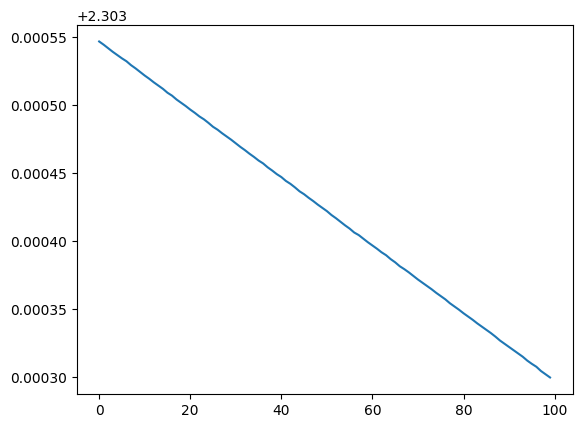



model의 output: [0.11497923 0.07748276 0.0890986  0.10759605 0.08638858 0.09065328
 0.09681318 0.11654424 0.1136393  0.10680476]
argmax를 한 후의 output: 7
accuracy: 0.07407407407407407



옵티마이저: {'sgd'} 학습률: {0.01} 

epoch: 0 loss: 2.3024308681488037
epoch: 10 loss: 2.3021717071533203
epoch: 20 loss: 2.301913261413574
epoch: 30 loss: 2.301652431488037
epoch: 40 loss: 2.3013899326324463
epoch: 50 loss: 2.301126480102539
epoch: 60 loss: 2.3008623123168945
epoch: 70 loss: 2.300598382949829
epoch: 80 loss: 2.3003342151641846
epoch: 90 loss: 2.300067901611328




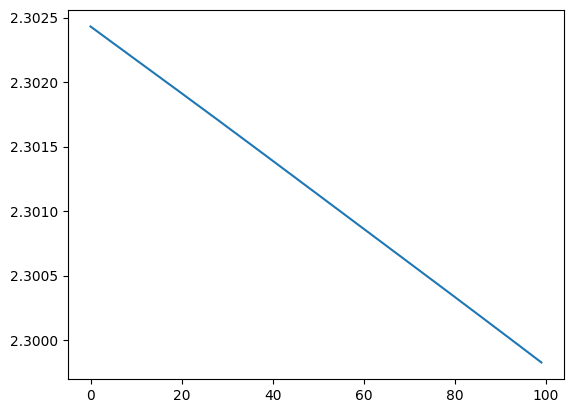



model의 output: [0.12286314 0.10789098 0.10881408 0.07883516 0.08597894 0.12799776
 0.09290569 0.09697304 0.09299547 0.08474582]
argmax를 한 후의 output: 5
accuracy: 0.16111111111111112



옵티마이저: {'sgd'} 학습률: {0.1} 

epoch: 0 loss: 2.3022565841674805
epoch: 10 loss: 2.299928903579712
epoch: 20 loss: 2.297513961791992
epoch: 30 loss: 2.294956684112549
epoch: 40 loss: 2.2922143936157227
epoch: 50 loss: 2.289155960083008
epoch: 60 loss: 2.285601854324341
epoch: 70 loss: 2.28127384185791
epoch: 80 loss: 2.2756950855255127
epoch: 90 loss: 2.2679553031921387




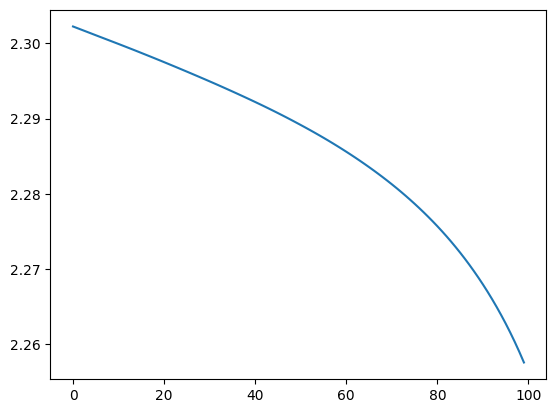



model의 output: [0.06029059 0.1370879  0.09671048 0.08836702 0.0986174  0.09596344
 0.11367536 0.10334984 0.10235663 0.10358132]
argmax를 한 후의 output: 1
accuracy: 0.5703703703703704



옵티마이저: {'adam'} 학습률: {0.001} 

epoch: 0 loss: 2.3034374713897705
epoch: 10 loss: 2.1452767848968506
epoch: 20 loss: 1.84417724609375
epoch: 30 loss: 1.6495966911315918
epoch: 40 loss: 1.5593674182891846
epoch: 50 loss: 1.503219485282898
epoch: 60 loss: 1.4824236631393433
epoch: 70 loss: 1.4723130464553833
epoch: 80 loss: 1.4677326679229736
epoch: 90 loss: 1.4657480716705322




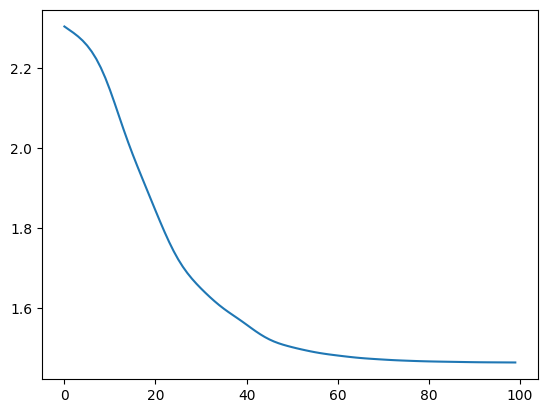



model의 output: [1.0676559e-07 9.9981052e-01 1.0610798e-06 6.9016033e-07 1.6483677e-06
 1.2142478e-05 1.2023221e-06 1.9337906e-06 1.6819741e-04 2.5081329e-06]
argmax를 한 후의 output: 1
accuracy: 0.9833333333333333



옵티마이저: {'adam'} 학습률: {0.01} 

epoch: 0 loss: 2.3035900592803955
epoch: 10 loss: 1.4914515018463135
epoch: 20 loss: 1.469377040863037
epoch: 30 loss: 1.4658547639846802
epoch: 40 loss: 1.4650760889053345
epoch: 50 loss: 1.465053915977478
epoch: 60 loss: 1.4650399684906006
epoch: 70 loss: 1.4650343656539917
epoch: 80 loss: 1.4650342464447021
epoch: 90 loss: 1.4650334119796753




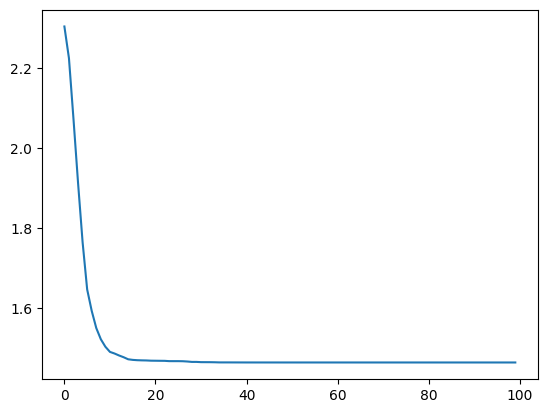



model의 output: [1.4145535e-36 1.0000000e+00 3.3989938e-24 6.5960974e-38 1.3656993e-26
 1.6180118e-21 1.2449870e-20 8.4344777e-38 4.6292444e-24 6.7557212e-36]
argmax를 한 후의 output: 1
accuracy: 0.9703703703703703



옵티마이저: {'adam'} 학습률: {0.1} 

epoch: 0 loss: 2.3033804893493652
epoch: 10 loss: 2.278585910797119
epoch: 20 loss: 2.2702128887176514
epoch: 30 loss: 2.296464204788208
epoch: 40 loss: 2.278951644897461
epoch: 50 loss: 2.282153367996216
epoch: 60 loss: 2.294063091278076
epoch: 70 loss: 2.294086456298828
epoch: 80 loss: 2.280561923980713
epoch: 90 loss: 2.2773711681365967




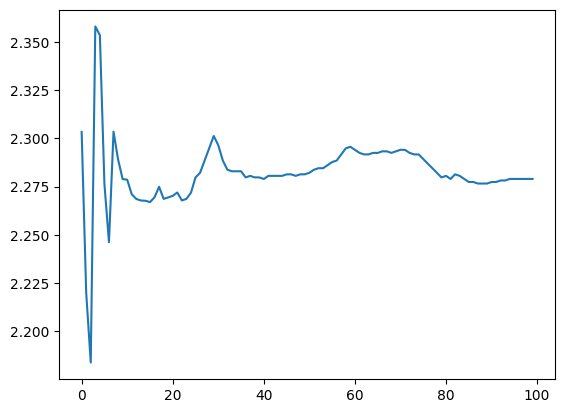



model의 output: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
argmax를 한 후의 output: 3
accuracy: 0.17962962962962964



옵티마이저: {'RMSprop'} 학습률: {0.001} 

epoch: 0 loss: 2.301983594894409
epoch: 10 loss: 1.498856544494629
epoch: 20 loss: 1.4699510335922241
epoch: 30 loss: 1.466138482093811
epoch: 40 loss: 1.4633989334106445
epoch: 50 loss: 1.4628149271011353
epoch: 60 loss: 1.462039589881897
epoch: 70 loss: 1.4617475271224976
epoch: 80 loss: 1.461606502532959
epoch: 90 loss: 1.46151602268219




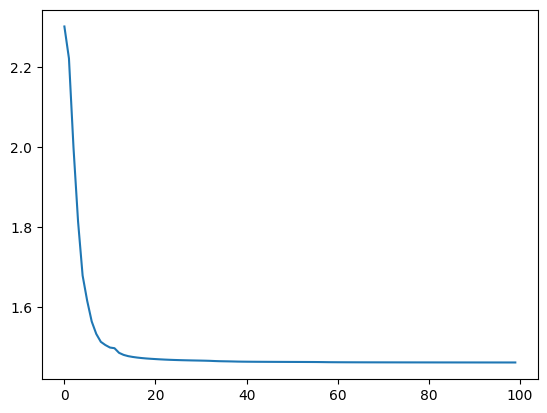



model의 output: [7.9490956e-06 9.9991822e-01 5.9290886e-07 5.8349992e-06 6.9219276e-08
 1.2793721e-06 5.5102882e-05 5.2880301e-07 8.4918893e-06 1.9228337e-06]
argmax를 한 후의 output: 1
accuracy: 0.9851851851851852



옵티마이저: {'RMSprop'} 학습률: {0.01} 

epoch: 0 loss: 2.303075075149536
epoch: 10 loss: 2.0841898918151855
epoch: 20 loss: 2.07122802734375
epoch: 30 loss: 2.0698885917663574
epoch: 40 loss: 2.0656042098999023
epoch: 50 loss: 2.0652520656585693
epoch: 60 loss: 2.067556142807007
epoch: 70 loss: 2.065661668777466
epoch: 80 loss: 2.064901113510132
epoch: 90 loss: 2.0808141231536865




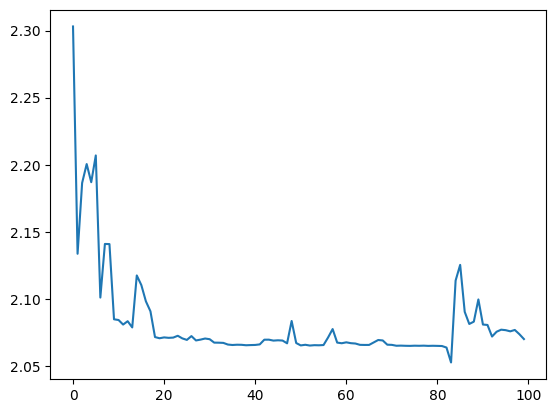



model의 output: [0.0000000e+00 1.0000000e+00 0.0000000e+00 6.6136471e-34 1.6058230e-38
 0.0000000e+00 7.5249728e-43 4.3798810e-35 0.0000000e+00 5.3836515e-26]
argmax를 한 후의 output: 1
accuracy: 0.37407407407407406



옵티마이저: {'RMSprop'} 학습률: {0.1} 

epoch: 0 loss: 2.302671432495117
epoch: 10 loss: 2.361707925796509
epoch: 20 loss: 2.361707925796509
epoch: 30 loss: 2.361707925796509
epoch: 40 loss: 2.361707925796509
epoch: 50 loss: 2.361707925796509
epoch: 60 loss: 2.361707925796509
epoch: 70 loss: 2.361707925796509
epoch: 80 loss: 2.361707925796509
epoch: 90 loss: 2.361707925796509




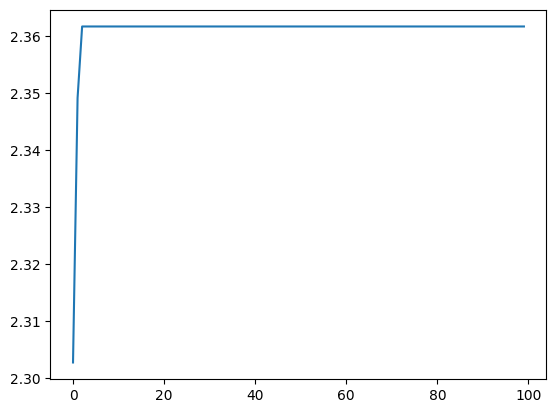



model의 output: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
argmax를 한 후의 output: 7
accuracy: 0.1


In [ ]:
for opt in opts:
    for lr in lrs:
        print("\n===================================================================\n")
        print('\n옵티마이저:', {opt}, '학습률:', {lr}, '\n')
        model = Model()
        optimizer = _get_optimizer(opt, lr)
        loss_fn = torch.nn.CrossEntropyLoss()

        losses = []

        # 학습데이터에 대한 학습 시작 (100 epoch)
        for epoch in range(100):

            # 경사(기울기) 초기화
            optimizer.zero_grad()

            # 순전파 계산
            hypothesis = model(x_train)

            # 오차 계산
            cost = loss_fn(hypothesis, y_train)

            # 역전파 계산
            cost.backward()

            # 경사(기울기) 업데이트
            optimizer.step()

            # 오차 리스트에 1 epoch에 대한 loss 값 추가
            losses.append(cost.item())

            # 10번째 epoch마다 loss 출력
            if epoch%10==0:
                print('epoch:', epoch, 'loss:', cost.item())

        print('\n')
        plt.plot(losses)
        plt.show()
        print('\n')

        # 모델 검증
        '''파이토치는 모든 연산과 기울기 값을 저장하는 특성이 있다.
        검증(or 테스트) 과정에서는 역전파가 필요하지 않기 때문에, with torch.no_grad()를 사용하여 기울기 값을 저장하지 않도록 한다.'''

        model.eval() # 모델을 평가할 때는 모든 노드를 사용하겠다는 의미, 모델학습에 드롭아웃이 적용되었다면 이때는 비활성화 된다.
        with torch.no_grad():
            y_pred = model(x_test)
            y_pred = y_pred.detach().numpy()
            predicted = np.argmax(y_pred, axis=1)
            accuracy = (accuracy_score(predicted, y_test))

        print(f'model의 output: {y_pred[0]}')
        print(f'argmax를 한 후의 output: {predicted[0]}')
        print(f'accuracy: {accuracy}')

        row={'loss': cost.item(), 'accuracy': accuracy, 'epoch': epoch,
             'optimizer': opt, 'learning_rate': lr}
        result1 = result1.append(row, ignore_index=True)

In [ ]:
result1.sort_values('accuracy', ascending=False)

,epoch,learning_rate,optimizer,loss,accuracy
6,99,0.001,RMSprop,1.461457,0.985185
3,99,0.001,adam,1.465028,0.983333
4,99,0.010,adam,1.465033,0.970370
2,99,0.100,sgd,2.257581,0.570370
7,99,0.010,RMSprop,2.069983,0.374074
5,99,0.100,adam,2.278971,0.179630
1,99,0.010,sgd,2.299827,0.161111
8,99,0.100,RMSprop,2.361708,0.100000
0,99,0.001,sgd,2.303300,0.074074


###3-2. 미니 배치 경사 하강법 (batch_size=256인 DataLoader 활용)

In [ ]:
model = Model()




옵티마이저: {'sgd'} 학습률: {0.001} 

epoch: 0 loss: 2.3038008213043213
epoch: 10 loss: 2.303685426712036
epoch: 20 loss: 2.3035786151885986
epoch: 30 loss: 2.3034727573394775
epoch: 40 loss: 2.303366184234619
epoch: 50 loss: 2.303257942199707
epoch: 60 loss: 2.30314564704895
epoch: 70 loss: 2.3030357360839844
epoch: 80 loss: 2.3029284477233887
epoch: 90 loss: 2.302821159362793




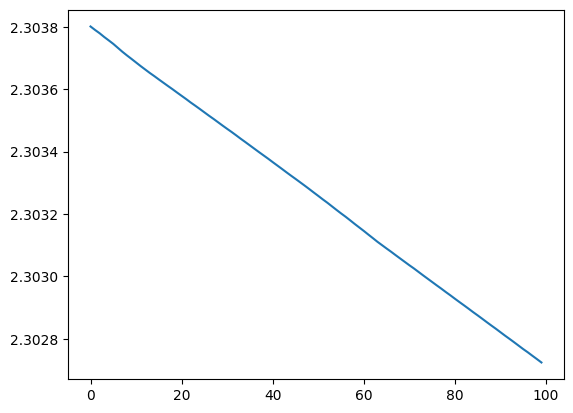



model의 output: [0.10691939 0.10669587 0.0827883  0.08670956 0.0856571  0.12431842
 0.10594514 0.11502873 0.08947347 0.09646415]
argmax를 한 후의 output: 5
accuracy: 0.05185185185185185



옵티마이저: {'sgd'} 학습률: {0.01} 

epoch: 0 loss: 2.304039478302002
epoch: 10 loss: 2.302839517593384
epoch: 20 loss: 2.301659345626831
epoch: 30 loss: 2.3004567623138428
epoch: 40 loss: 2.2992117404937744
epoch: 50 loss: 2.297934055328369
epoch: 60 loss: 2.2966370582580566
epoch: 70 loss: 2.2952773571014404
epoch: 80 loss: 2.2938344478607178
epoch: 90 loss: 2.2922873497009277




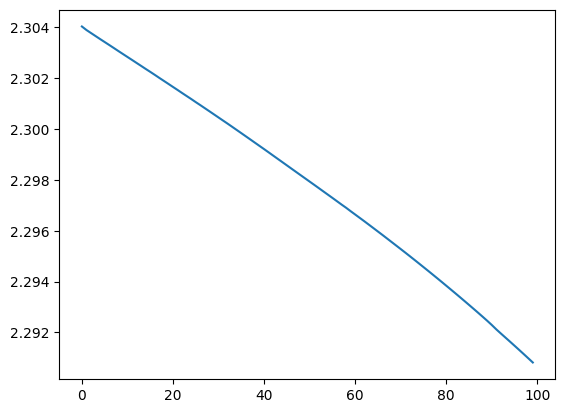



model의 output: [0.07427733 0.11931615 0.10867666 0.07317107 0.08560634 0.09623349
 0.12460365 0.08944635 0.11175252 0.11691645]
argmax를 한 후의 output: 6
accuracy: 0.3055555555555556



옵티마이저: {'sgd'} 학습률: {0.1} 

epoch: 0 loss: 2.3007969856262207
epoch: 10 loss: 2.281552791595459
epoch: 20 loss: 2.187176465988159
epoch: 30 loss: 1.9212746620178223
epoch: 40 loss: 1.6740939617156982
epoch: 50 loss: 1.5852231979370117
epoch: 60 loss: 1.5621528625488281
epoch: 70 loss: 1.5403244495391846
epoch: 80 loss: 1.5007269382476807
epoch: 90 loss: 1.4860525131225586




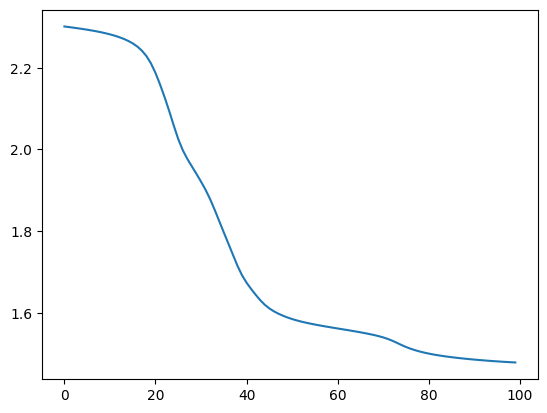



model의 output: [1.59792421e-06 9.92521226e-01 1.20281894e-03 1.33950161e-04
 1.09415814e-04 1.85204763e-03 2.16789846e-03 1.41629353e-05
 1.96546107e-03 3.11886179e-05]
argmax를 한 후의 output: 1
accuracy: 0.9814814814814815



옵티마이저: {'adam'} 학습률: {0.001} 

epoch: 0 loss: 2.2725942134857178
epoch: 10 loss: 1.5444835424423218
epoch: 20 loss: 1.467591643333435
epoch: 30 loss: 1.4646999835968018
epoch: 40 loss: 1.4616262912750244
epoch: 50 loss: 1.4614089727401733
epoch: 60 loss: 1.4613292217254639
epoch: 70 loss: 1.4612901210784912
epoch: 80 loss: 1.4612699747085571
epoch: 90 loss: 1.4612369537353516




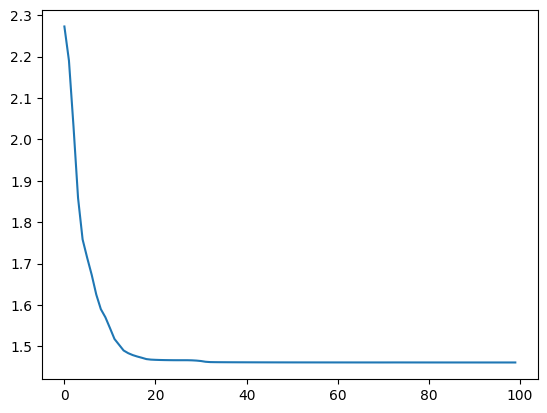



model의 output: [4.8261444e-09 9.9986041e-01 5.5414430e-06 9.4386763e-07 8.5394055e-07
 9.9729565e-05 3.1800064e-05 1.6703039e-08 7.5060166e-07 6.8392416e-09]
argmax를 한 후의 output: 1
accuracy: 0.987037037037037



옵티마이저: {'adam'} 학습률: {0.01} 

epoch: 0 loss: 1.784515142440796
epoch: 10 loss: 1.468618392944336
epoch: 20 loss: 1.4612205028533936
epoch: 30 loss: 1.461193561553955
epoch: 40 loss: 1.4611564874649048
epoch: 50 loss: 1.464876413345337
epoch: 60 loss: 1.508235216140747
epoch: 70 loss: 1.4697959423065186
epoch: 80 loss: 1.461417317390442
epoch: 90 loss: 1.4691904783248901




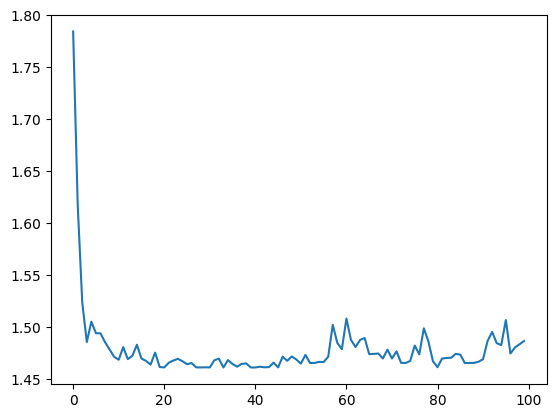



model의 output: [0.0000000e+00 1.0000000e+00 5.7947517e-18 0.0000000e+00 1.0385568e-34
 6.5861028e-44 6.0166781e-25 7.1754413e-39 9.9924444e-17 1.3141818e-34]
argmax를 한 후의 output: 1
accuracy: 0.9592592592592593



옵티마이저: {'adam'} 학습률: {0.1} 

epoch: 0 loss: 2.362438201904297
epoch: 10 loss: 2.362438201904297
epoch: 20 loss: 2.362438201904297
epoch: 30 loss: 2.362438201904297
epoch: 40 loss: 2.362438201904297
epoch: 50 loss: 2.362438201904297
epoch: 60 loss: 2.362438201904297
epoch: 70 loss: 2.362438201904297
epoch: 80 loss: 2.362438201904297
epoch: 90 loss: 2.362438201904297




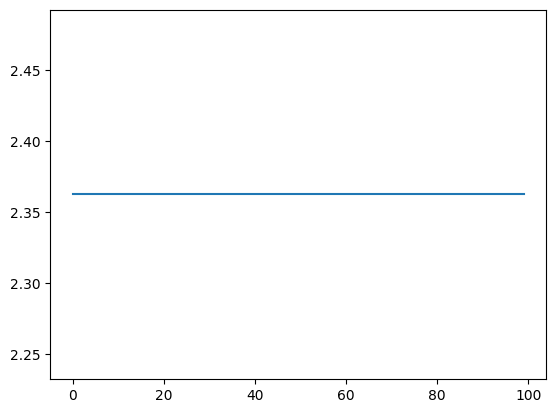



model의 output: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
argmax를 한 후의 output: 0
accuracy: 0.1



옵티마이저: {'RMSprop'} 학습률: {0.001} 

epoch: 0 loss: 1.7493555545806885
epoch: 10 loss: 1.4629857540130615
epoch: 20 loss: 1.4616330862045288
epoch: 30 loss: 1.461400032043457
epoch: 40 loss: 1.4612892866134644
epoch: 50 loss: 1.4612337350845337
epoch: 60 loss: 1.4612044095993042
epoch: 70 loss: 1.4611871242523193
epoch: 80 loss: 1.461175560951233
epoch: 90 loss: 1.4611682891845703




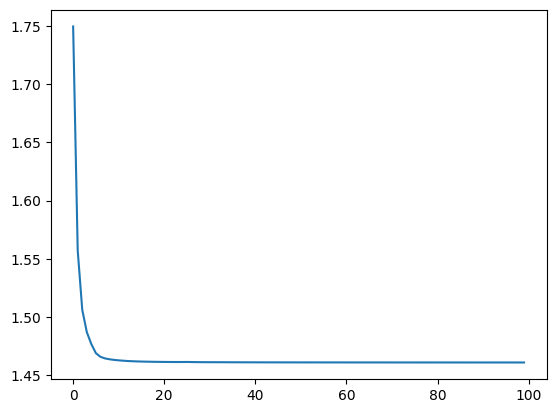



model의 output: [1.3496036e-07 9.9999928e-01 1.4867233e-07 1.1146356e-11 9.0590909e-08
 6.4404865e-10 9.4309609e-09 9.9543378e-09 1.6005555e-07 2.7824933e-07]
argmax를 한 후의 output: 1
accuracy: 0.9851851851851852



옵티마이저: {'RMSprop'} 학습률: {0.01} 

epoch: 0 loss: 2.1722099781036377
epoch: 10 loss: 2.1645495891571045
epoch: 20 loss: 2.1389381885528564
epoch: 30 loss: 2.134791374206543
epoch: 40 loss: 2.139260768890381
epoch: 50 loss: 2.13893985748291
epoch: 60 loss: 2.1808598041534424
epoch: 70 loss: 2.1468772888183594
epoch: 80 loss: 2.1388206481933594
epoch: 90 loss: 2.1133062839508057




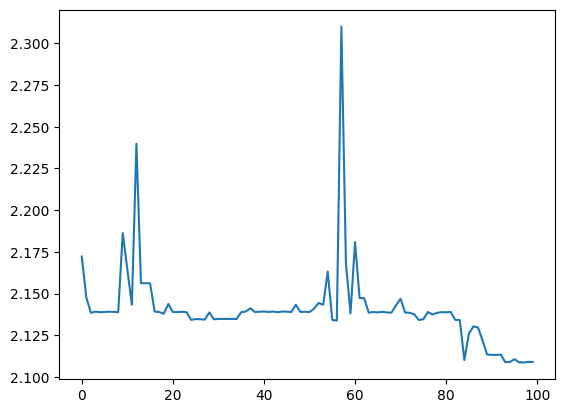



model의 output: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
argmax를 한 후의 output: 2
accuracy: 0.3



옵티마이저: {'RMSprop'} 학습률: {0.1} 

epoch: 0 loss: 2.328103542327881
epoch: 10 loss: 2.328103542327881
epoch: 20 loss: 2.328103542327881
epoch: 30 loss: 2.328103542327881
epoch: 40 loss: 2.328103542327881
epoch: 50 loss: 2.328103542327881
epoch: 60 loss: 2.328103542327881
epoch: 70 loss: 2.328103542327881
epoch: 80 loss: 2.328103542327881
epoch: 90 loss: 2.328103542327881




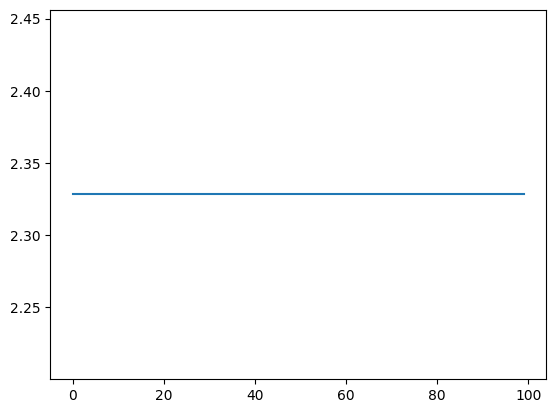



model의 output: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
argmax를 한 후의 output: 2
accuracy: 0.09814814814814815


In [ ]:
for opt in opts:
    for lr in lrs:
        criterion = torch.nn.CrossEntropyLoss()
        print("\n===================================================================\n")
        print('\n옵티마이저:', {opt}, '학습률:', {lr}, '\n')
        model = Model()
        optimizer = _get_optimizer(opt, lr)
        loss_fn = torch.nn.CrossEntropyLoss()

        losses = []

        # 학습데이터에 대한 학습 시작 (100 epoch)
        for epoch in range(100):
            for x, y in dataloader:

                # 경사(기울기) 초기화
                optimizer.zero_grad()

                # 순전파 및 오차 계산
                cost = criterion(model(x), y)

                # 역전파 계산
                cost.backward()

                # 경사(기울기) 업데이트
                optimizer.step()

            # 오차 리스트에 1 epoch에 대한 loss 값 추가
            losses.append(cost.item())

            if epoch%10==0:
                print('epoch:', epoch, 'loss:', cost.item())

        print('\n')
        plt.plot(losses)
        plt.show()
        print('\n')

        with torch.no_grad():
            model = model.to('cpu')
            y_pred = model(x_test)
            y_pred = y_pred.detach().numpy()
            predicted = np.argmax(y_pred, axis=1)
            accuracy = (accuracy_score(predicted, y_test))

        print(f'model의 output: {y_pred[0]}')
        print(f'argmax를 한 후의 output: {predicted[0]}')
        print(f'accuracy: {accuracy}')

        row = {'loss': cost.item(), 'accuracy': accuracy, 'epoch': epoch,
               'optimizer': opt, 'learning_rate': lr}
        result2 = result2.append(row, ignore_index=True)

In [ ]:
result2.sort_values('accuracy', ascending=False)

,epoch,learning_rate,optimizer,loss,accuracy
3,99,0.001,adam,1.461221,0.987037
6,99,0.001,RMSprop,1.461164,0.985185
2,99,0.100,sgd,1.479000,0.981481
4,99,0.010,adam,1.486621,0.959259
1,99,0.010,sgd,2.290812,0.305556
7,99,0.010,RMSprop,2.109026,0.300000
5,99,0.100,adam,2.362438,0.100000
8,99,0.100,RMSprop,2.328104,0.098148
0,99,0.001,sgd,2.302724,0.051852


<h3>1. sgd (lr : 0.1 > 0.01 > 0.001)</h3> <br>

**결과분석 : lr가 클 수록 성능이 좋다.** <br>

SGD의 대표적인 단점은 비등방성(anisotropy) 함수와 같이 방향에 따라 기울기가 달라지는 함수에 대해서는 탐색 경로가 비효율적이라는 점이다.

또한 학습률이 낮으면 minimum으로 곧장 최적화하지 못하고 지그재그로 이동하게되면서 local minimum에 빠질 수 있으며, 학습률이 높으면 최적화 자체를 실패할 수 있다는 단점이 존재한다.

**이러한 점을 감안해 볼 때, 학습률이 너무 낮을 경우 local minimum 혹은 안장점 (saddle point)에서 학습이 종결되었음을 유추해볼 수 있다. 오히려 학습률 (보폭)이 클 때 이러한 지점을 통과하고 global minimum에 도달할 수 있었던게 아닐까 추측해보았다.**<br><br>

<h3>2. RMSprop (lr : 0.001 > 0.01 > 0.1)</h3> <br>

**결과분석 : lr가 작을 수록 성능이 좋다.** <br>

Adagrad의 단점을 보완한 방법. <br>
Adagrad는 변수(가중치)의 업데이트 횟수에 따라 학습률을 조정하는 방법이다. 많이 변화하지 않는 변수들의 학습률은 크게 하고, 많이 변화하는 변수들의 학습률은 적게 한다.
**즉, 많이 변화한 변수는 최적값에 근접했을 것이라는 가정 하에 작은 크기로 이동하면서 세밀하게 값을 조정하고, 반대로 적게 변화한 변수들은 학습률을 크게 하여 빠르게 오차 값을 줄이고자 하는 방법**

**이러한 점을 고려해볼 때, 학습률이 작을수록 각 변수들에 대한 세밀한 조정이 가능할 것으로 보인다. 따라서 학습률이 작을수록 더 좋은 성능을 보인 것으로 추측**해보았다.

(참고. AdaGrad에서 G는 현재 시간까지의 변화량의 합으로 정의되기 때문에 시간이 지날수록 증가하게 되고 학습률은 감소하지만, RMSProp에서는 이전의 변화량과 현재의 변화량의 지수 평균으로 정의되기 때문에 학습률이 급격하게 감소하는 현상을 방지할 수 있다.)<br><br>


<h3>3. adam (lr : 0.001 > 0.01 > 0.1)</h3> <br>

**결과분석 : lr가 작을 수록 성능이 좋다.** <br>
adam은 모멘텀과 RMSprop의 장점을 결합한 경사하강법.<br>

따라서 RMSprop과 동일한 이유로 학습률이 작을수록 더 좋은 성능을 보였을 것이라고 추측.
<br><br>


<h3>adam optimizer를 활용하고 lr을 0.001로 설정하였을 때, acc가 0.987037로 가장 높은 성능을 보였다.</h3>

**<h3>물론 model (layer 수, node 수 등)을 바꾸어도 됩니다. 최대한 다양한 시도를 해본 후에, 하이퍼파라미터가 결과에 어떤 영향을 미쳤는지 분석해보시면 됩니다.</h3>**

## 4. 텐서보드 활용 학습과정 모니터링

In [ ]:
optimizer = _get_optimizer('adam', 0.001)
criteria = torch.nn.CrossEntropyLoss()

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('../tensorboard')

for epoch in range(100):
    model.train()
    batch_loss = 0.0

    for i, (x, y) in enumerate(dataloader):
        outputs = model(x)
        loss = criterion(outputs, y)
        writer.add_scalar('Loss', loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

writer.close()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir {'../tensorboard'}

텐서보드 활용법에 관해서는 구글에 검색해보시면 자세한 활용법을 아실 수 있습니다.

##6. 참고문헌

- <딥러닝 파이토치 교과서> (서지영 저) <br>
- 기계학습 옵티마이저 성능 평가 (https://koreascience.kr/article/JAKO202029462558311.pdf)<br>
- 그림으로 보는 다양한 Optimization 기법들 (https://hyunw.kim/blog/2017/11/01/Optimization.html) <br>
- 최적화 알고리즘 Optimizer (https://pgnv.tistory.com/43)<br>
- 학습률 설정 (https://forensics.tistory.com/28)